In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
import pandas as pd
from itertools import cycle
from scipy.interpolate import UnivariateSpline

MLP - UNBALANCED DATASET

In [2]:
# Load Dataset
df = pd.read_csv("/content/Unbalanced_Multiclass.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,1.942833,1.793557,-6.121474,-1.031132,0.487107,-0.346116,0.242493,-0.255091,-1.933793,0.456129,...,0.021294,-0.876791,-2.804382,-0.772752,0.902250,-0.283821,1.158110,-0.703144,-1.142507,8
1,-0.498266,4.290355,0.924083,-1.281493,8.153378,-2.302476,0.615296,-3.871441,1.491185,3.666561,...,-0.030226,1.076776,-1.426662,0.743057,0.212868,1.043947,0.948273,0.706128,-0.491125,8
2,-1.027512,3.363755,1.828574,-0.495802,7.458820,-2.484852,0.378415,-2.248700,-1.301424,4.136351,...,0.472101,1.206932,-0.923404,0.566657,0.293071,-0.145078,1.759649,0.516351,0.492429,8
3,2.736756,-2.241731,0.404660,-0.167861,-0.125442,0.496706,1.664382,-1.271026,0.213782,0.962099,...,-1.376614,-0.559114,-0.335620,0.088591,0.080121,-0.085828,0.038390,-0.096909,-0.426436,8
4,0.685796,0.223385,-2.080131,-0.011414,4.090118,0.650177,2.411078,2.637664,-1.594057,0.283371,...,0.540901,0.354731,-0.933172,-0.888606,0.902017,0.506791,0.640292,0.129010,0.092228,8


In [3]:
# Splitting Data
X = df.drop(columns=["target"])  # Features
y = df["target"].values          # Target Variable

In [ ]:
df['target'].value_counts()

In [4]:
# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
# Convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Changed to long for CrossEntropyLoss
y_test_tensor = torch.tensor(y_test, dtype=torch.long)    # Removed unsqueeze

In [6]:
# Create PyTorch Dataloader
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes=14):  # 14 output classes
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)  # Output layer matches class count

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        # Removed sigmoid (CrossEntropyLoss handles logits)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x  # Return raw logits

In [8]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_size=X_train.shape[1]).to(device)

device

device(type='cpu')

In [9]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [10]:
# Training Loop
epochs = 100
best_val_loss = float("inf")
patience = 10
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

        running_loss += loss.item()

    train_accuracy = correct_train / total_train

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor.to(device))
        val_loss = criterion(val_outputs, y_test_tensor.to(device)).item()

        # Calculate validation accuracy
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_total = y_test_tensor.size(0)
        val_correct = (val_predicted == y_test_tensor.to(device)).sum().item()
        val_accuracy = val_correct / val_total

    scheduler.step()

    # Print metrics
    print(f"Epoch [{epoch+1}/{epochs}] => "
          f"Train Acc: {train_accuracy:.4f}, "
          f"Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Val Acc: {val_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, ")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/100] => Train Acc: 0.5012, Train Loss: 2.4204, Val Acc: 0.7308, Val Loss: 2.1384, 
Epoch [2/100] => Train Acc: 0.7046, Train Loss: 1.7464, Val Acc: 0.7308, Val Loss: 1.3977, 
Epoch [3/100] => Train Acc: 0.7046, Train Loss: 1.2327, Val Acc: 0.7308, Val Loss: 1.3391, 
Epoch [4/100] => Train Acc: 0.7046, Train Loss: 1.1071, Val Acc: 0.7308, Val Loss: 1.2016, 
Epoch [5/100] => Train Acc: 0.7046, Train Loss: 0.9880, Val Acc: 0.7308, Val Loss: 1.1416, 
Epoch [6/100] => Train Acc: 0.7046, Train Loss: 0.9098, Val Acc: 0.7308, Val Loss: 1.0909, 
Epoch [7/100] => Train Acc: 0.7070, Train Loss: 0.8452, Val Acc: 0.7500, Val Loss: 1.0365, 
Epoch [8/100] => Train Acc: 0.7530, Train Loss: 0.7738, Val Acc: 0.7981, Val Loss: 0.9947, 
Epoch [9/100] => Train Acc: 0.8063, Train Loss: 0.6940, Val Acc: 0.8365, Val Loss: 0.9362, 
Epoch [10/100] => Train Acc: 0.8281, Train Loss: 0.6210, Val Acc: 0.8365, Val Loss: 0.9153, 
Epoch [11/100] => Train Acc: 0.8402, Train Loss: 0.5847, Val Acc: 0.8365, Val L

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Accuracy: 0.8365
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.85      0.85      0.85        13
           7       0.00      0.00      0.00         1
           8       0.84      1.00      0.91        76
           9       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2

    accuracy                           0.84       104
   macro avg       0.19      0.21      0.20       104
weighted avg       0.72      0.84      0.77       104



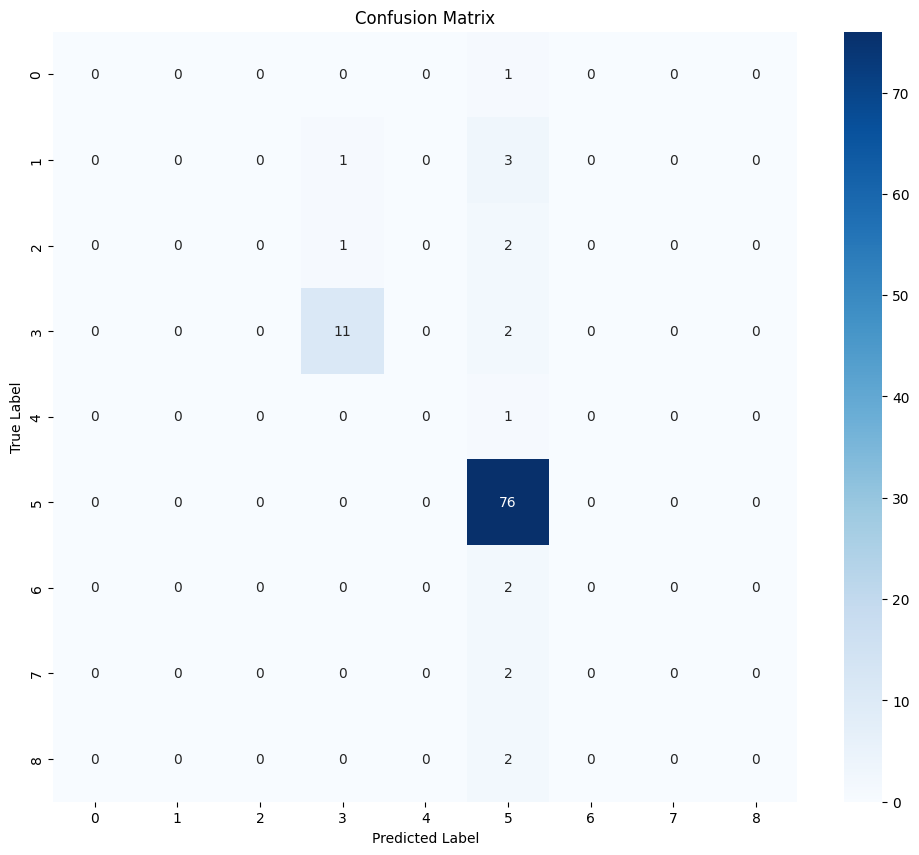

In [11]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor.to(device))
    y_pred = torch.argmax(y_pred_logits, dim=1).cpu().numpy()
    y_score = model(X_test_tensor.to(device)).cpu().numpy()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')  # Changed to weighted
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(12,10))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [12]:
print("Unique Classes in y_train:", len(np.unique(y_train)))
print("Unique Classes in y_test:", len(np.unique(y_test)))

Unique Classes in y_train: 13
Unique Classes in y_test: 9


Classes in y_test: [ 0  1  2  3  7  8  9 11 13]



<ipython-input-13-8ddf70919d65>:29: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl = UnivariateSpline(fpr[class_id], tpr[class_id], s=0.3)  # s=smooting factor


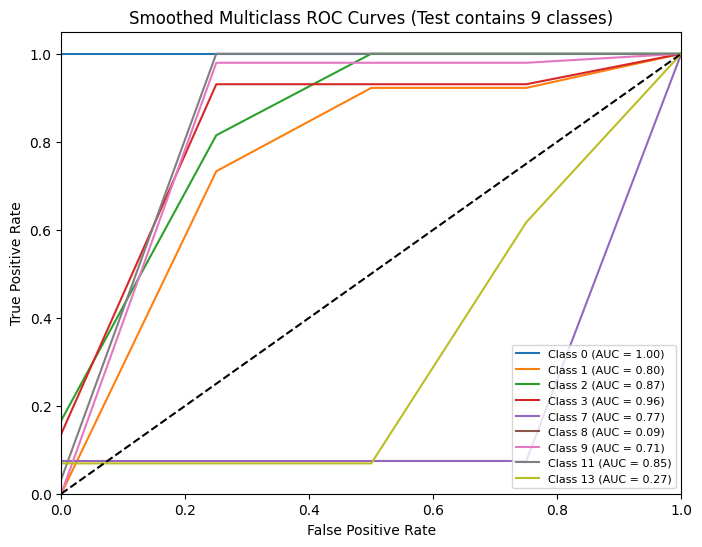

In [13]:
# Get class information
classes_present = np.unique(y_test)
n_classes = len(classes_present)

print(f"Classes in y_test: {classes_present}\n")

# Binarize labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=classes_present)

# Compute ROC metrics for existing classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_id in enumerate(classes_present):
    fpr[class_id], tpr[class_id], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[class_id] = auc(fpr[class_id], tpr[class_id])


# After computing fpr and tpr for each class
plt.figure(figsize=(8, 6))
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

for class_id, color in zip(classes_present, colors):
    # Smoothing with cubic spline interpolation
    if len(fpr[class_id]) > 3:  # Need at least 4 points for smoothing
        fpr_smooth = np.linspace(0, 1, 5)
        spl = UnivariateSpline(fpr[class_id], tpr[class_id], s=0.3)  # s=smooting factor
        tpr_smooth = spl(fpr_smooth)

        # Ensure monotonic increasing
        tpr_smooth = np.maximum.accumulate(tpr_smooth)
        tpr_smooth = np.clip(tpr_smooth, 0, 1)

        plt.plot(fpr_smooth, tpr_smooth, color=color, lw=1.5,
                 label=f'Class {class_id} (AUC = {roc_auc[class_id]:.2f})')
    else:
        plt.plot(fpr[class_id], tpr[class_id], color=color, lw=1.5,
                 label=f'Class {class_id} (AUC = {roc_auc[class_id]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Smoothed Multiclass ROC Curves (Test contains {n_classes} classes)')
plt.legend(loc="lower right", prop={'size': 8})
plt.show()

MLP - BALANCED DATASET

In [14]:
# Load Dataset
df = pd.read_csv("/content/Balanced_Multiclass.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,1.942833,1.793557,-6.121474,-1.031132,0.487107,-0.346116,0.242493,-0.255091,-1.933793,0.456129,...,0.021294,-0.876791,-2.804382,-0.772752,0.902250,-0.283821,1.158110,-0.703144,-1.142507,8
1,-0.498266,4.290355,0.924083,-1.281493,8.153378,-2.302476,0.615296,-3.871441,1.491185,3.666561,...,-0.030226,1.076776,-1.426662,0.743057,0.212868,1.043947,0.948273,0.706128,-0.491125,8
2,-1.027512,3.363755,1.828574,-0.495802,7.458820,-2.484852,0.378415,-2.248700,-1.301424,4.136351,...,0.472101,1.206932,-0.923404,0.566657,0.293071,-0.145078,1.759649,0.516351,0.492429,8
3,2.736756,-2.241731,0.404660,-0.167861,-0.125442,0.496706,1.664382,-1.271026,0.213782,0.962099,...,-1.376614,-0.559114,-0.335620,0.088591,0.080121,-0.085828,0.038390,-0.096909,-0.426436,8
4,0.685796,0.223385,-2.080131,-0.011414,4.090118,0.650177,2.411078,2.637664,-1.594057,0.283371,...,0.540901,0.354731,-0.933172,-0.888606,0.902017,0.506791,0.640292,0.129010,0.092228,8


In [15]:
# Splitting Data
X = df.drop(columns=["target"])  # Features
y = df["target"].values          # Target Variable

In [ ]:
df['target'].value_counts()

In [16]:
# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [17]:
# Convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Changed to long for CrossEntropyLoss
y_test_tensor = torch.tensor(y_test, dtype=torch.long)    # Removed unsqueeze

In [18]:
# Create PyTorch Dataloader
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes=14):  # 14 output classes
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)  # Output layer matches class count

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        # Removed sigmoid (CrossEntropyLoss handles logits)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x  # Return raw logits

In [20]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_size=X_train.shape[1]).to(device)

device

device(type='cpu')

In [21]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [22]:
# Training Loop
epochs = 100
best_val_loss = float("inf")
patience = 10
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

        running_loss += loss.item()

    train_accuracy = correct_train / total_train

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor.to(device))
        val_loss = criterion(val_outputs, y_test_tensor.to(device)).item()

        # Calculate validation accuracy
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_total = y_test_tensor.size(0)
        val_correct = (val_predicted == y_test_tensor.to(device)).sum().item()
        val_accuracy = val_correct / val_total

    scheduler.step()

    # Print metrics
    print(f"Epoch [{epoch+1}/{epochs}] => "
          f"Train Acc: {train_accuracy:.4f}, "
          f"Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Val Acc: {val_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, ")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/100] => Train Acc: 0.6414, Train Loss: 1.5151, Val Acc: 0.8765, Val Loss: 0.5259, 
Epoch [2/100] => Train Acc: 0.9321, Train Loss: 0.2927, Val Acc: 0.9698, Val Loss: 0.1439, 
Epoch [3/100] => Train Acc: 0.9723, Train Loss: 0.1215, Val Acc: 0.9767, Val Loss: 0.0922, 
Epoch [4/100] => Train Acc: 0.9852, Train Loss: 0.0723, Val Acc: 0.9835, Val Loss: 0.0558, 
Epoch [5/100] => Train Acc: 0.9876, Train Loss: 0.0537, Val Acc: 0.9893, Val Loss: 0.0379, 
Epoch [6/100] => Train Acc: 0.9932, Train Loss: 0.0345, Val Acc: 0.9961, Val Loss: 0.0265, 
Epoch [7/100] => Train Acc: 0.9939, Train Loss: 0.0275, Val Acc: 0.9922, Val Loss: 0.0291, 
Epoch [8/100] => Train Acc: 0.9944, Train Loss: 0.0233, Val Acc: 0.9932, Val Loss: 0.0274, 
Epoch [9/100] => Train Acc: 0.9973, Train Loss: 0.0147, Val Acc: 0.9912, Val Loss: 0.0284, 
Epoch [10/100] => Train Acc: 0.9973, Train Loss: 0.0150, Val Acc: 0.9932, Val Loss: 0.0209, 
Epoch [11/100] => Train Acc: 0.9976, Train Loss: 0.0101, Val Acc: 0.9922, Val L

Accuracy: 0.9932
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        78
           1       1.00      1.00      1.00        67
           2       0.99      1.00      0.99        69
           3       0.95      1.00      0.98        80
           4       1.00      1.00      1.00        75
           5       1.00      1.00      1.00        65
           6       1.00      1.00      1.00        72
           7       0.99      1.00      0.99        82
           8       1.00      0.92      0.96        83
           9       1.00      1.00      1.00        79
          10       1.00      1.00      1.00        74
          11       1.00      1.00      1.00        59
          12       1.00      1.00      1.00        71
          13       1.00      1.00      1.00        74

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028



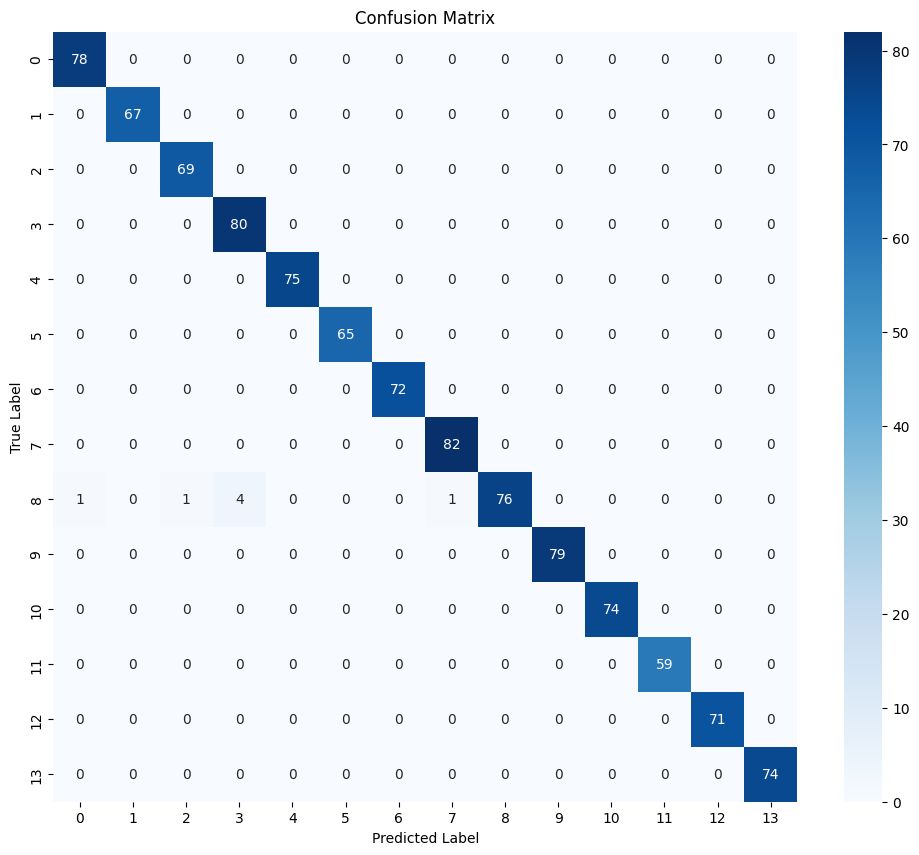

In [23]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor.to(device))
    y_pred = torch.argmax(y_pred_logits, dim=1).cpu().numpy()
    y_score = model(X_test_tensor.to(device)).cpu().numpy()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')  # Changed to weighted
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(12,10))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [24]:
print("Unique Classes in y_train:", len(np.unique(y_train)))
print("Unique Classes in y_test:", len(np.unique(y_test)))

Unique Classes in y_train: 14
Unique Classes in y_test: 14


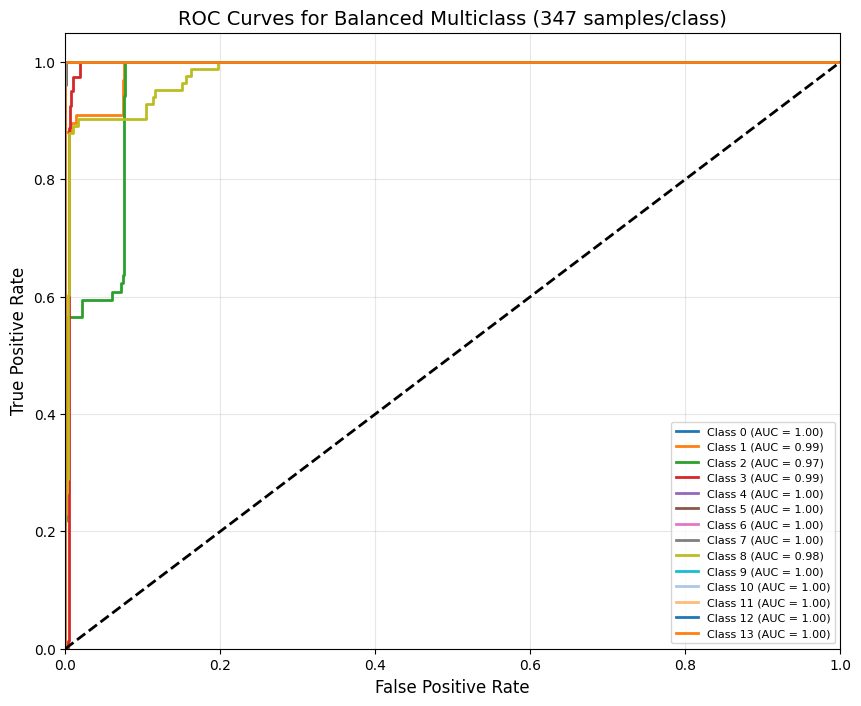

In [25]:
# Get all classes (should be 0-13 for your balanced dataset)
classes = np.unique(y_test)
n_classes = len(classes)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=classes)

# Get model predictions (ensure this outputs probabilities for all classes)
with torch.no_grad():
    y_score = model(X_test_tensor.to(device)).cpu().numpy()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_id in enumerate(classes):
    fpr[class_id], tpr[class_id], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[class_id] = auc(fpr[class_id], tpr[class_id])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
               '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
               '#bcbd22', '#17becf', '#aec7e8', '#ffbb78'])

for class_id, color in zip(classes, colors):
    plt.plot(fpr[class_id], tpr[class_id], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'
             ''.format(class_id, roc_auc[class_id]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Balanced Multiclass (347 samples/class)', fontsize=14)
plt.legend(loc="lower right", prop={'size': 8})
plt.grid(alpha=0.3)
plt.show()